<a href="https://colab.research.google.com/github/admhan/Deep-Learning-For-Image-Analysis-Lab/blob/main/Lab1_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab1 — Part 2: Training on MNIST

**Course**: Deep Learning for Image Analysis

**Class**: M2 IASD App  

**Professor**: Mehyar MLAWEH

---

In this part, we move from a **toy dataset** to a **real image dataset**.  
We will train a neural network on **MNIST**, **without using CNNs**.

The goal is to understand **why CNNs are needed**, not to use them yet.


## Learning objectives

After this part, you should understand:
- How images are represented as **vectors**
- How a neural network processes image data
- How multi-class classification works
- Why fully-connected networks are **not optimal** for vision tasks


## 0) Environment setup

Make sure you are using **GPU**:
- Runtime → Change runtime type → GPU


In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 1) Imports


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms


## 2) The MNIST dataset

MNIST contains **handwritten digit images**:
- Image size: **28 × 28**
- Number of channels: **1 (grayscale)**
- Number of classes: **10** (digits 0–9)

Each image is originally a **2D grid of pixels**, but a fully-connected network
expects a **vector** as input.

https://www.youtube.com/watch?v=SrT6QkQUH4Q

### 🔍 Question (conceptual)

- **How many pixels does one MNIST image contain?**  
Une image MNIST a une taille de **28 × 28 pixels**, donc elle contient  
**28 × 28 = 784 pixels**.

- **What will be the size of the input vector after flattening?**  
Après l’opération de *flattening*, l’image 2D (28 × 28) est transformée en un vecteur 1D de  
**784 valeurs**.


In [3]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

len(train_dataset), len(test_dataset)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.58MB/s]


(60000, 10000)

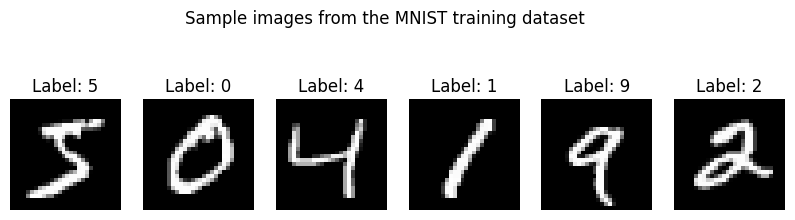

In [4]:

num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


## 3) DataLoader and mini-batches

We use **mini-batches** to train efficiently.

⚠️ Choosing the batch size is a trade-off between speed and memory.


In [5]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 4) Model: Fully-connected neural network (MLP)

### Two experiments with the same model

In this part, we train **the same neural network (MLP)** on two versions of MNIST:

1. **Original MNIST** (centered digits)
2. **Transformed MNIST** (shifted and rotated digits)

#### Experiment 1: MNIST (baseline)

1. **Flatten** the image `(1, 28, 28)` → `(784,)`
2. Feed it to a standard MLP

Architecture:
- Input: 784
- Hidden layer: 256 neurons + ReLU
- Output: 10 neurons (one per class)

The output represents **class scores (logits)**.



In [6]:
class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_MNIST().to(device)
model


MLP_MNIST(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

### ✅ TODO — Understanding the model

1. How many parameters does this model have?
2. Which layer contains most of the parameters?
Explain briefly.


### Réponses

#### 1. Combien de paramètres ce modèle contient-il ?

Le modèle contient **203 530 paramètres** au total.

Détail par couche :

- **Linear(784 → 256)**  
  - Poids : 784 × 256 = 200 704  
  - Biais : 256  
  - **Total : 200 960 paramètres**

- **Linear(256 → 10)**  
  - Poids : 256 × 10 = 2 560  
  - Biais : 10  
  - **Total : 2 570 paramètres**

**Nombre total de paramètres :**  
200 960 + 2 570 = **203 530**

---

#### 2. Quelle couche contient le plus de paramètres ? Expliquez brièvement.

La **première couche entièrement connectée (Linear(784 → 256))** contient la grande majorité des paramètres.

**Explication :**  
Cette couche relie chaque pixel d’entrée (784) à chacun des 256 neurones cachés.  
Dans un réseau entièrement connecté, le nombre de paramètres dépend du produit  
*taille de l’entrée × taille de la sortie*, ce qui explique pourquoi cette couche domine largement le nombre total de paramètres.



 **Loss function and optimizer**

This is a **multi-class classification** problem.

- We use `CrossEntropyLoss`
- It combines **Softmax + Negative Log-Likelihood**


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



**Training loop**

The training logic is **exactly the same** as before.
Only the data and the model changed.


In [8]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


Epoch 1/3 - Loss: 0.3641
Epoch 2/3 - Loss: 0.1604
Epoch 3/3 - Loss: 0.1111


**Evaluation on the test set**

We compute the **classification accuracy**.


In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
accuracy


0.9692

#### Experiment 2: Shifted and rotated MNIST

We now apply random shifts and rotations to the training images.

This breaks the assumption that digits are always centered and aligned.

The **model architecture remains exactly the same**.


In [10]:
transform_augmented = transforms.Compose([
    transforms.RandomAffine(
        degrees=50,
        translate=(0.2, 0.2)
    ),
    transforms.ToTensor()
])

train_dataset_aug = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform_augmented
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_dataset_aug), len(test_dataset)


(60000, 10000)

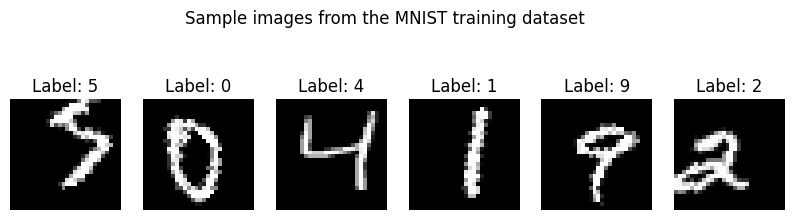

In [11]:

num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset_aug[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


Train the **same model** using the augmented training dataset.

Compare:
- Training loss
- Test accuracy

with the results obtained using original MNIST.


In [12]:
# TODO
# train
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader_aug:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    training_loss = running_loss / len(train_loader_aug)

    # test accuracy
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Training loss: {training_loss:.4f} | "
        f"Test accuracy: {test_accuracy:.4f}"
    )


Epoch 1/3 | Training loss: 1.0847 | Test accuracy: 0.8944
Epoch 2/3 | Training loss: 0.6609 | Test accuracy: 0.9008
Epoch 3/3 | Training loss: 0.5661 | Test accuracy: 0.9162


In [14]:
## Evaluation

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions = outputs.argmax(dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy:.4f}")


Test accuracy: 0.9162


## 5) What do we observe? (Reflection)

 - Why does the same fully-connected model perform worse on shifted and rotated MNIST images compared to vanilla MNIST?

 - What limitation of fully-connected networks does this experiment reveal when dealing with images?

- Based on these results, what properties should a better model for image data have?

✍️ Write short answers (2–3 lines).



## 5) Réponses

- 1)
Parce qu’un MLP traite chaque pixel indépendamment de sa position.  
Les décalages et rotations modifient fortement l’organisation des pixels, ce qui perturbe les représentations apprises.

- 2)
Les réseaux fully-connected ne sont **ni invariants aux translations ni aux rotations** et n’exploitent pas la structure spatiale des images.

- 3)
Il devrait exploiter les relations spatiales locales et être plus robuste aux transformations géométriques, par exemple grâce à des **convolutions** et au **partage de poids**.



## 6) Looking ahead — why CNNs?

In the next assignment, we will replace this MLP with **Convolutional Neural Networks**.

CNNs:
- Exploit **spatial structure**
- Share parameters
- Achieve **much higher accuracy** on image tasks

👉 You should expect a **significant accuracy improvement** in the next assignment.
